[View in Colaboratory](https://colab.research.google.com/github/Santosh-Gupta/Book2Vec/blob/master/Book2VecTraining.ipynb)

In [0]:
import re
from collections import Counter
import time

import numpy as np

from __future__ import print_function
import collections
import math
import numpy as np
import random
import zipfile
import os

from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import pandas as pd

!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from numpy import genfromtxt
import sys

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

vocabulary_size = 10001 #according to https://github.com/zygmuntz/goodbooks-10k there are 10000 books in the dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
dl_id = input("Enter Gdrive file ID for books: ") # 1w3uSNtc1srNaWoRHwbUE9o3baokloh9U

# DOWNLOAD ZIP
print ("Downloading  file")
myzip = drive.CreateFile({'id': dl_id})
myzip.GetContentFile('books.csv')

print( os.listdir() )


Enter Gdrive file ID for books: 1w3uSNtc1srNaWoRHwbUE9o3baokloh9U
['datalab', 'books.csv', '.forever', '.ipython', '.cache', '.local', '.keras', '.config']


In [0]:
b = pd.read_csv( 'books.csv' )
b.head(30)
bookDictionary = b.set_index('book_id').to_dict()['original_title']
bookDictionary[5]

'The Great Gatsby'

In [0]:
dl_id = input("Enter Gdrive file ID for Refined Ratings: ") #cbow2: 1HmTeQO9XSmyf97hAd25fS_c9FQJJe4xh
                                                                                           #cbow2 second shuffle: 1b6vtvXgtbyjBoPd_FxqtegJjaacIUnTH
                                                                                          #cbow2 for analogies 19S42TwSar4TpU2nZ5TF9_NQJvznq6LwB
                                                                                          #cbow2 for analogies 2nd shuffle 1Oap_518xDf9v-zUcVkS4l1_ULdkAIF0l

# DOWNLOAD ZIP
print ("Downloading  file")
myDownload = drive.CreateFile({'id': dl_id})
myDownload.GetContentFile('DlRefinedRatings.csv')
print( os.listdir() )


Enter Gdrive file ID for Refined Ratings: 1HmTeQO9XSmyf97hAd25fS_c9FQJJe4xh
['datalab', 'books.csv', '.forever', '.ipython', '.cache', 'DlRefinedRatings.csv', '.local', '.keras', '.config']


In [0]:
my_data = genfromtxt('DlRefinedRatings.csv', delimiter=',' ,  dtype=int, skip_header=1)

print(my_data[0:15])

[[3255627   27372      39       4       1      18      81]
 [5925223   27372     262       5       1      23      -1]
 [3255582   27372      41       5       1      27      -1]
 [3255581   27372    1059       4       1      28      -1]
 [4893342   27372      21       5       1      30      -1]
 [3255586   27372       5       5       1      42      -1]
 [5790609   27372    1012       4       1      42      -1]
 [3255589   27372     294       4       1      48      -1]
 [5701878   27372     581       4       1      53      -1]
 [3856525   27372     655       4       1      64      -1]
 [3255588   27372      12       5       1      81      -1]
 [3255569   27372     626       5       1      92      -1]
 [5692358   27372     252       5       1      93      -1]
 [3255557   27372     615       5       1      95      -1]
 [3255597   27372     290       5       1     100      -1]]


In [0]:
data_index = 0
epoch_index = 0
recEpoch_indexA = 0 #Used to help keep store of the total number of epoches with the models

def generate_batch(batch_size, cbow_window): 
  
    global data_index, epoch_index
    
    span = 2 * cbow_window + 1 
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32) 
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    userbracketDF = my_data[data_index: data_index+ my_data[data_index, 6], 2 ]
    headernumber = my_data[:,6]
    assert headernumber[data_index] != -1, 'data_index in incorrect spot'
        
    n=0
    while n < batch_size:
      b=0
      while b < len(userbracketDF) and n < batch_size :
        if b== 0:
          potentialBatch=userbracketDF[b+1:len(userbracketDF)]
        else:
          firsthalf = userbracketDF[0:b]
          secondhalf = userbracketDF[b+1:len(userbracketDF)]
          potentialBatch = np.concatenate((firsthalf, secondhalf), axis=0)
        potentialBatchSet = set(potentialBatch)
        if 2*cbow_window > len(potentialBatchSet):
          print('potentialBatchSet is ', potentialBatchSet)
          raise Exception('Dataset is for a smaller Cbow Window, data needs to be checked') 
        batch[n] = random.sample(potentialBatchSet,  2*cbow_window)
        labels[n,0]=userbracketDF[b]
        n=n+1
        b=b+1
      
      data_index = (data_index + headernumber[data_index] ) % len(headernumber)
      
      if data_index == 0:
        epoch_index = epoch_index + 1
        print('Completed %d Epochs' % epoch_index)
      
      assert headernumber[data_index] != -1, 'data_index in incorrect spot'
      userbracketDF = my_data[data_index: data_index+ my_data[data_index, 6], 2 ]

    return batch, labels     
      
here, goes = generate_batch(20, 2) 
print('batch', here)
print('labels', goes)

batch [[   6  147 2058  262]
 [  25  655  215    3]
 [ 667    3  991   50]
 [  36  221   56  626]
 [   5   30   25  324]
 [3372  327   21  626]
 [9742 6565   69   24]
 [  39   37   27  369]
 [   1  369  459 1375]
 [   5  117 1012   64]
 [  61  164 4145 5434]
 [2390   50  615  164]
 [6565  454 5434  667]
 [ 117  147   27 1080]
 [ 626   85  262   27]
 [ 454  101  940 1059]
 [ 991 1046   85  324]
 [ 292   36 1375  541]
 [   5  615  139  221]
 [1059   24  215    1]]
labels [[  39]
 [ 262]
 [  41]
 [1059]
 [  21]
 [   5]
 [1012]
 [ 294]
 [ 581]
 [ 655]
 [  12]
 [ 626]
 [ 252]
 [ 615]
 [ 290]
 [ 259]
 [6565]
 [ 454]
 [4145]
 [ 459]]


In [0]:
batch_size = 256 #2^8

embedding_size = 256 # 2^8 Dimension of the embedding vector.
cbow_window =1
#skip_window = 1 # How many words to consider left and right.
#num_skips = 2 # How many times to reuse an input to generate a label.
                      
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 60 # Random set of words to evaluate similarity on.
valid_window = 4000 # Only pick dev samples in the head of the distribution.
#valid_examples = np.array(random.sample(range(valid_window), valid_size))
# Random set of words to evaluate similarity on.
num_sampled = 65 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(): # 
 
  valid_examples = np.array(random.sample(range(1, valid_window), valid_size)) #put inside graph to get new words each time
  #for same words each time keep outside graph
  
  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, cbow_window*2 ])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  valid_datasetSM = tf.constant(valid_examples, dtype=tf.int32)

  epochCount = tf.get_variable( 'epochCount', initializer= 0) #to store epoch count to total # of epochs are known
  update_epoch = tf.assign(epochCount, epochCount + 1)
  # Variables.
  embeddings = tf.get_variable( 'embeddings', 
    initializer= tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.get_variable( 'softmax_weights',
    initializer= tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  
  softmax_biases = tf.get_variable('softmax_biases', 
    initializer= tf.zeros([vocabulary_size]),  trainable=False )
  #Made softmax biases untrainable because they do not seem to give significant
  #improvement. Also allows for a 2nd set of embeddings to analyze. 
  #https://stats.stackexchange.com/questions/249565/word2vec-neural-network-bias-units/250464
  #Both Richard Sorcher and Andrew Ng's NLP lectures do not contain a bias term
  #in their equations. 
  
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset) #train data set is
  #the center word for skip-gram mode. So we're looking up the vector for that
  #center word. Gets the embeddings for every word in the batch
  # Compute the softmax loss, using a sample of the negative labels each time.
  embed_reshaped = tf.reshape( embed, [batch_size*cbow_window*2, embedding_size] )
  
  segments= np.arange(batch_size).repeat(cbow_window*2)
  
  averaged_embeds = tf.segment_mean(embed_reshaped, segments, name=None)
  
  #def loss_function():
    #return tf.reduce_mean( tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=averaged_embeds,
                               #labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=averaged_embeds,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
            #fun fact remove_accidental_hits: A bool. whether to remove "accidental hits" where 
            #a sampled class equals one of the target classes. Default is True.

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss) 
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  
  normalized_embeddings = embeddings / norm
  normalized_embeddingsSM = softmax_weights / normSM
  
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset) #A bunch of normalized embeddings, randomly selected when valid_examples was initilized. 
  valid_embeddingsSM = tf.nn.embedding_lookup(
    normalized_embeddingsSM, valid_datasetSM)
  
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) #multiplies each normalized embeds from valid_examples with all 
                                                                                                                        #other normalized embeds. Used to find most similiar embeds later
  similaritySM = tf.matmul(valid_embeddingsSM, tf.transpose(normalized_embeddingsSM)) 
  #important to note that to note that throughout all these matrix operations, indices of the original embedding and SM matrices are kept in tact
  #this is important for when we want to match an embedding with it's corresponding book, since the book dictionary uses the index as the key
                                                                                                                              
  saver = tf.train.Saver()

In [0]:
def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

In [0]:
loadModel = input("Would you like to load a checkpoint? Type y or n: ") 

if loadModel == 'y':
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  zip_id = input("Enter Gdrive file ID for tensorflow models: ") 

  if not os.path.exists('checkpointsBook2VecCbowWindow1Downloaded'):
      os.makedirs('checkpointsBook2VecCbowWindow1Downloaded')

  # DOWNLOAD ZIP
  print ("Downloading zip file")
  myzip = drive.CreateFile({'id': zip_id})
  myzip.GetContentFile('model.zip')

  # UNZIP ZIP
  print ("Uncompressing zip file")
  zip_ref = zipfile.ZipFile('model.zip', 'r')
  zip_ref.extractall('checkpointsBook2VecCbowWindow1Downloaded/')
  zip_ref.close()

  print( os.getcwd() )
  print( os.listdir('./checkpointsBook2VecCbowWindow1Downloaded') )

Would you like to load a checkpoint? Type y or n: y
Enter Gdrive file ID for tensorflow models: 1uhw6EsylWcbFpCWWSJPR6xByMIWnMAhr
Uncompressing zip file
/content
['checkpoint', 'bookVec.ckpt.index', 'bookVec.ckpt.meta', 'bookVec.ckpt.data-00000-of-00001']


In [0]:
num_steps = 3000000

if 'loadModel' not in locals() and 'loadModel' not in globals():
  loadModel = n

uploadModel = drive.CreateFile() #used to upload checkpoints when graph is run

with tf.Session(graph=graph) as session:
  
  if loadModel == 'y':
    saver.restore(session, './checkpointsBook2VecCbowWindow1Downloaded/bookVec.ckpt' )
  else:  
    tf.global_variables_initializer().run() #Don't initalize variables after a checkpoint has been restored
  
  print('Initialized')
  average_loss = 0
  saveIteration = 1
  for step in range(1, num_steps):
    
    batch_data, batch_labels = generate_batch(
      batch_size, cbow_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict) 

    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = bookDictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1] #Returns index of most similiar values. Starts from 1 because index 0 will just be the same book
        log = 'Nearest to %s : | ' % valid_word
        for k in range(top_k):
          close_word = bookDictionary[nearest[k]]
          log = '%s %s | ' % (log, close_word) #Prints out most similiar books, in descending order from most to least similiar
        print(log)
      
    if step % 30000 == 0:
      recEpoch_indexA =  epoch_index - recEpoch_indexA #how much did the epoch_index since it was last checked
      #epochCount = tf.add(  epochCount, recEpoch_indexA, name=None )
      for nE in range(0, recEpoch_indexA ):
        session.run(update_epoch) #session run calls tend to be huge bottlenecks, keep in mind while determining the frequency
      recEpoch_indexA = epoch_index
      print('recEpoch_indexA is', recEpoch_indexA)
      print( 'epochCount.eval() is ', epochCount.eval() )
      print('epoch_index is ' , epoch_index)
      
      save_path = saver.save(session, "checkpointsBook2VecCbowWindow1/bookVec.ckpt") #Save checkpoint
      
      auth.authenticate_user()
      gauth = GoogleAuth() #Gdrive authenticion code placed here since it expires after some time
      gauth.credentials = GoogleCredentials.get_application_default()
      drive = GoogleDrive(gauth) 
      uploadModel = drive.CreateFile() #Need to also create drive object with updated authenticion
      
      chptName = 'B2VCbowW1Embed256ckpt'+str(saveIteration)
      zipfolder(chptName, 'checkpointsBook2VecCbowWindow1')
      uploadModel.SetContentFile(chptName+".zip")
      uploadModel.Upload()
      
      print("Checkpoint uploaded to Google Drive")
      saveIteration += 1
      os.remove(chptName+".zip") #Remove checkpoint zip file after upload

                
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()

Initialized
Average loss at step 2000: 3.288511
Average loss at step 4000: 3.284991
Average loss at step 6000: 3.292980
Average loss at step 8000: 3.280576
Average loss at step 10000: 3.298557
Average loss at step 12000: 3.280894
Completed 1 Epochs
Average loss at step 14000: 3.284789
Average loss at step 16000: 3.276345
Average loss at step 18000: 3.290849
Average loss at step 20000: 3.292071
Nearest to Mile high (Up In The Air #2) : |  Reflected in You |  In Flight |  Entwined with You |  The Edge of Never |  Real |  Fallen Too Far (Too Far, #1) |  On Dublin Street |  Driven | 
Nearest to Gregor and the Prophecy of Bane : |  Gregor and the Curse of the Warmbloods |  Gregor the Overlander |  Gregor and the Marks of Secret |  Gregor and the Code of Claw |  What The Dead Know |  Sea Glass |  Cinder |  Peter and the Starcatchers | 
Nearest to Blood Promise : |  Frostbite |  Spirit Bound |  Last Sacrifice  |  nan |  Shadow Kiss |  Bloodlines |  The Golden Lily |  The Indigo Spell | 
Neare

In [0]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
two_d_embeddingsSM = tsne.fit_transform(final_embeddingsSM[1:num_points+1, :])

NameError: ignored

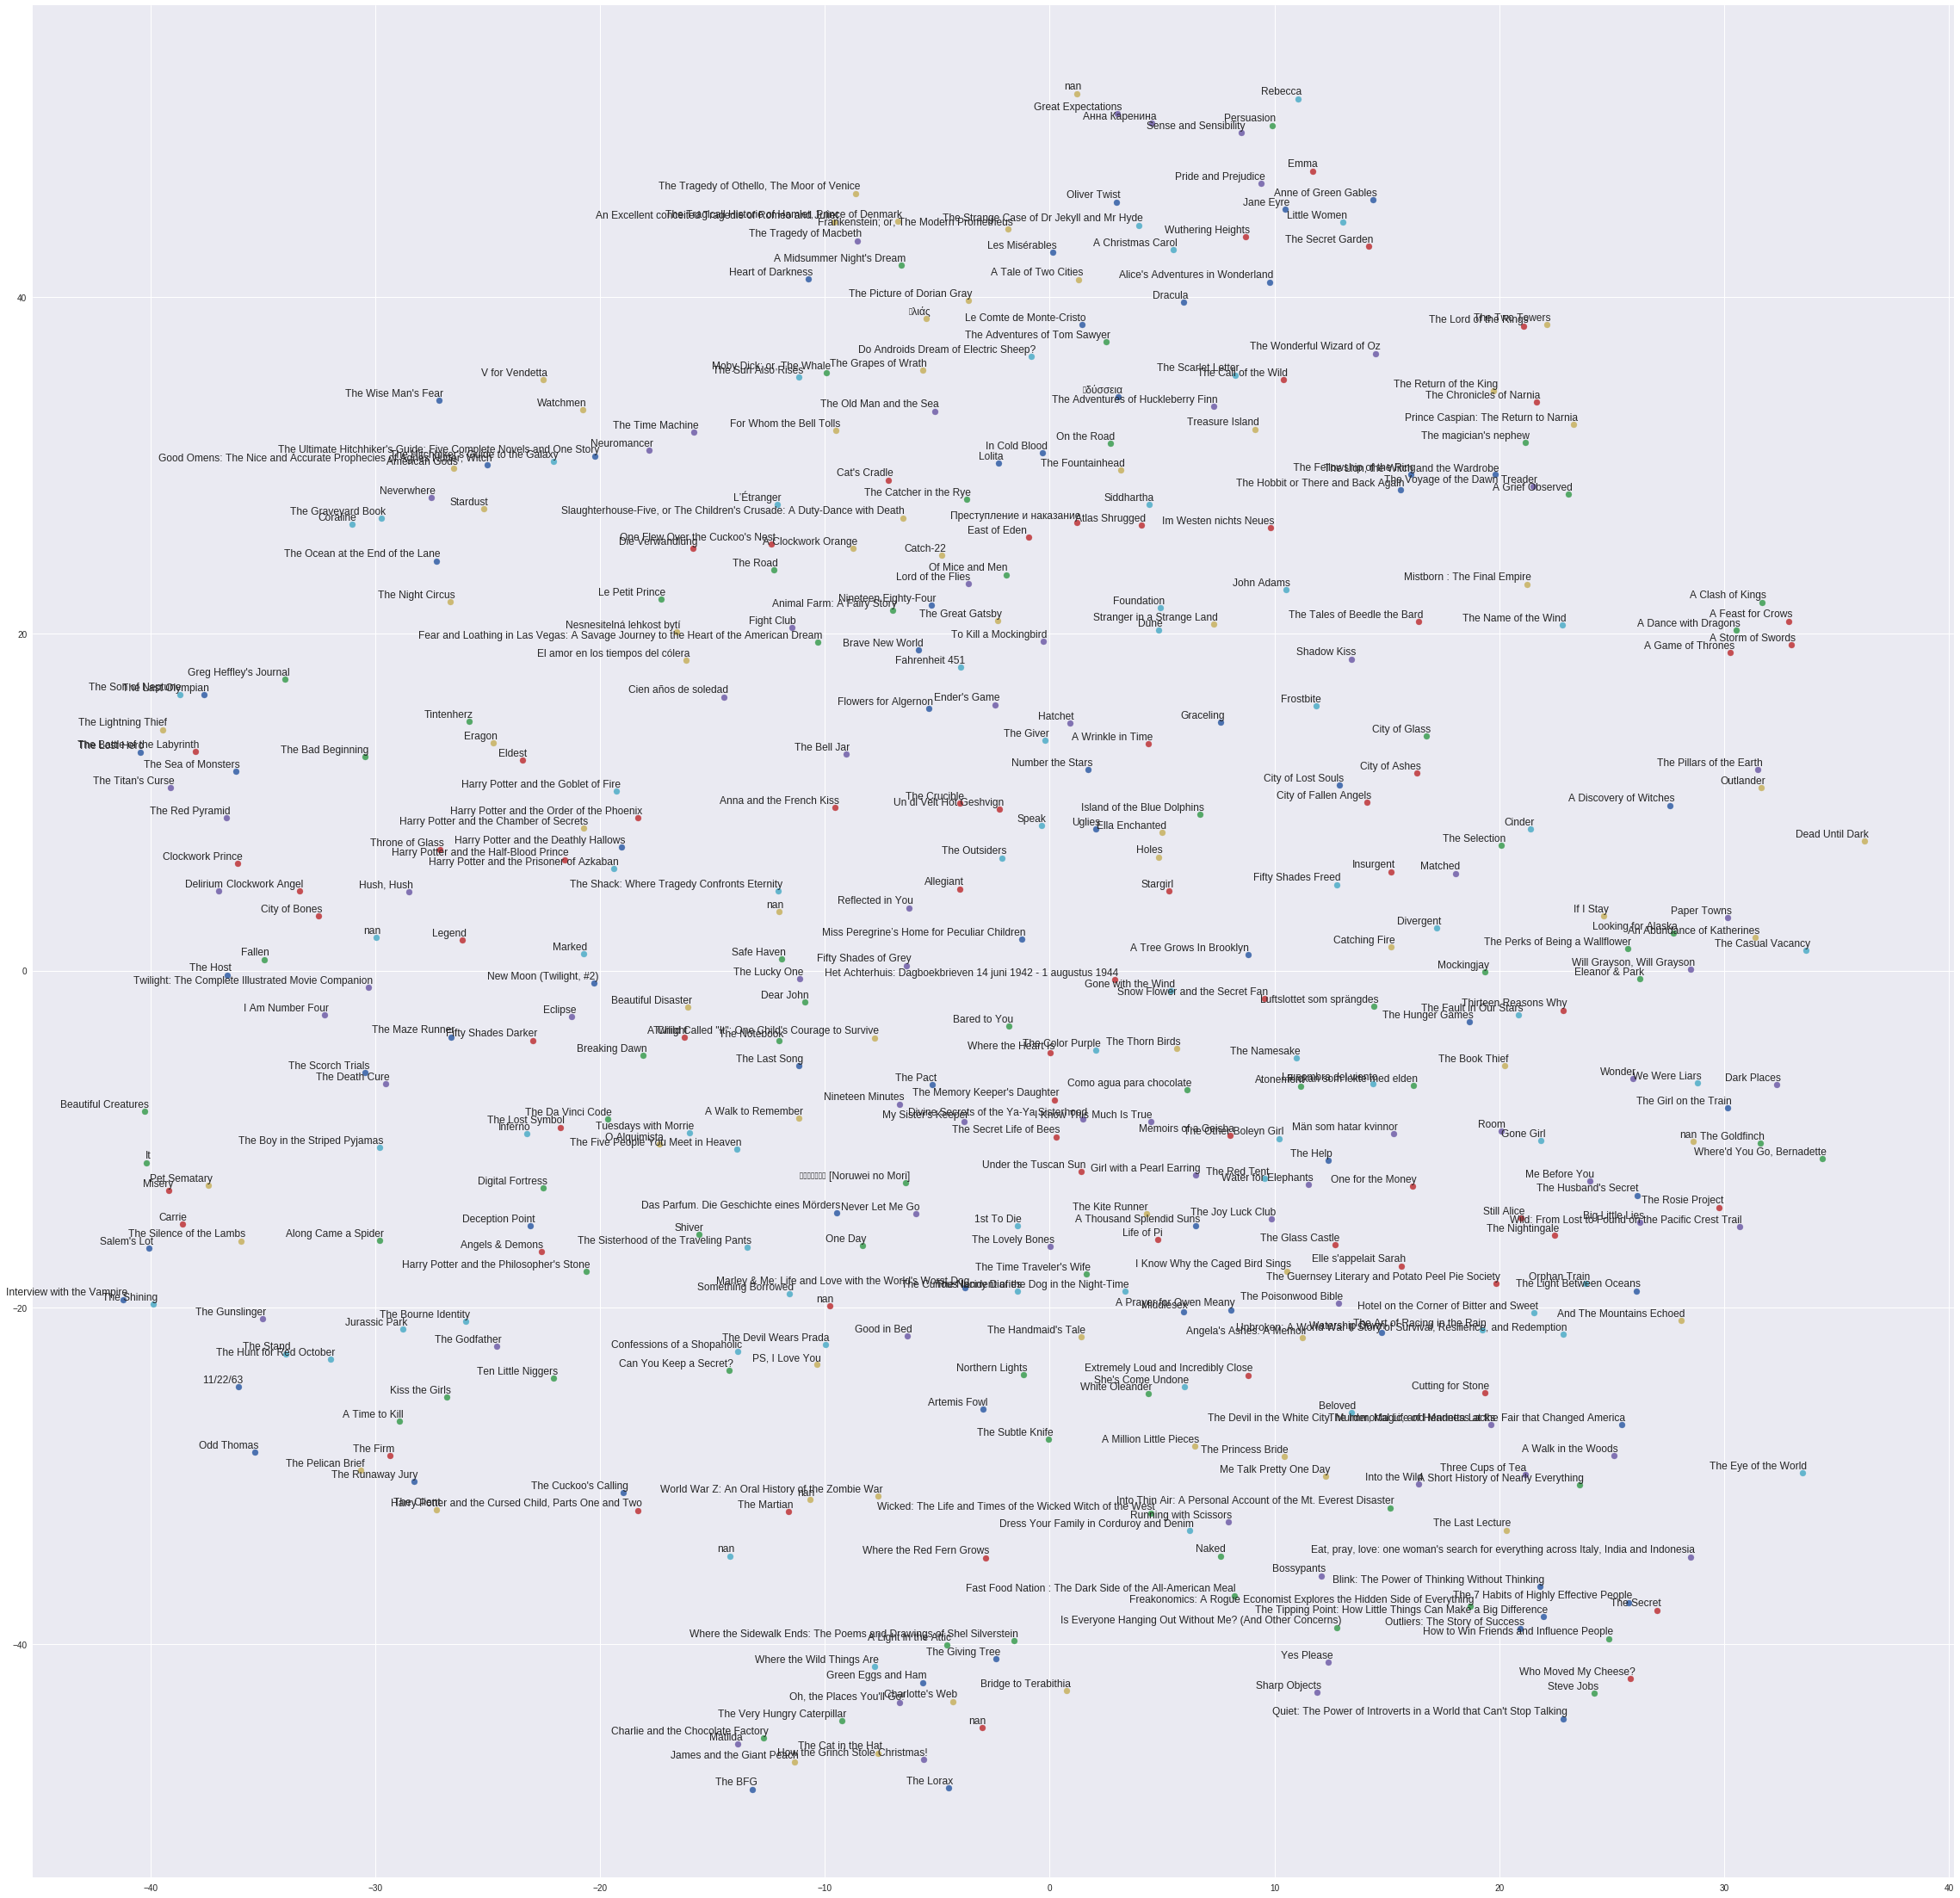

In [0]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(50,50))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

books = [bookDictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, books)

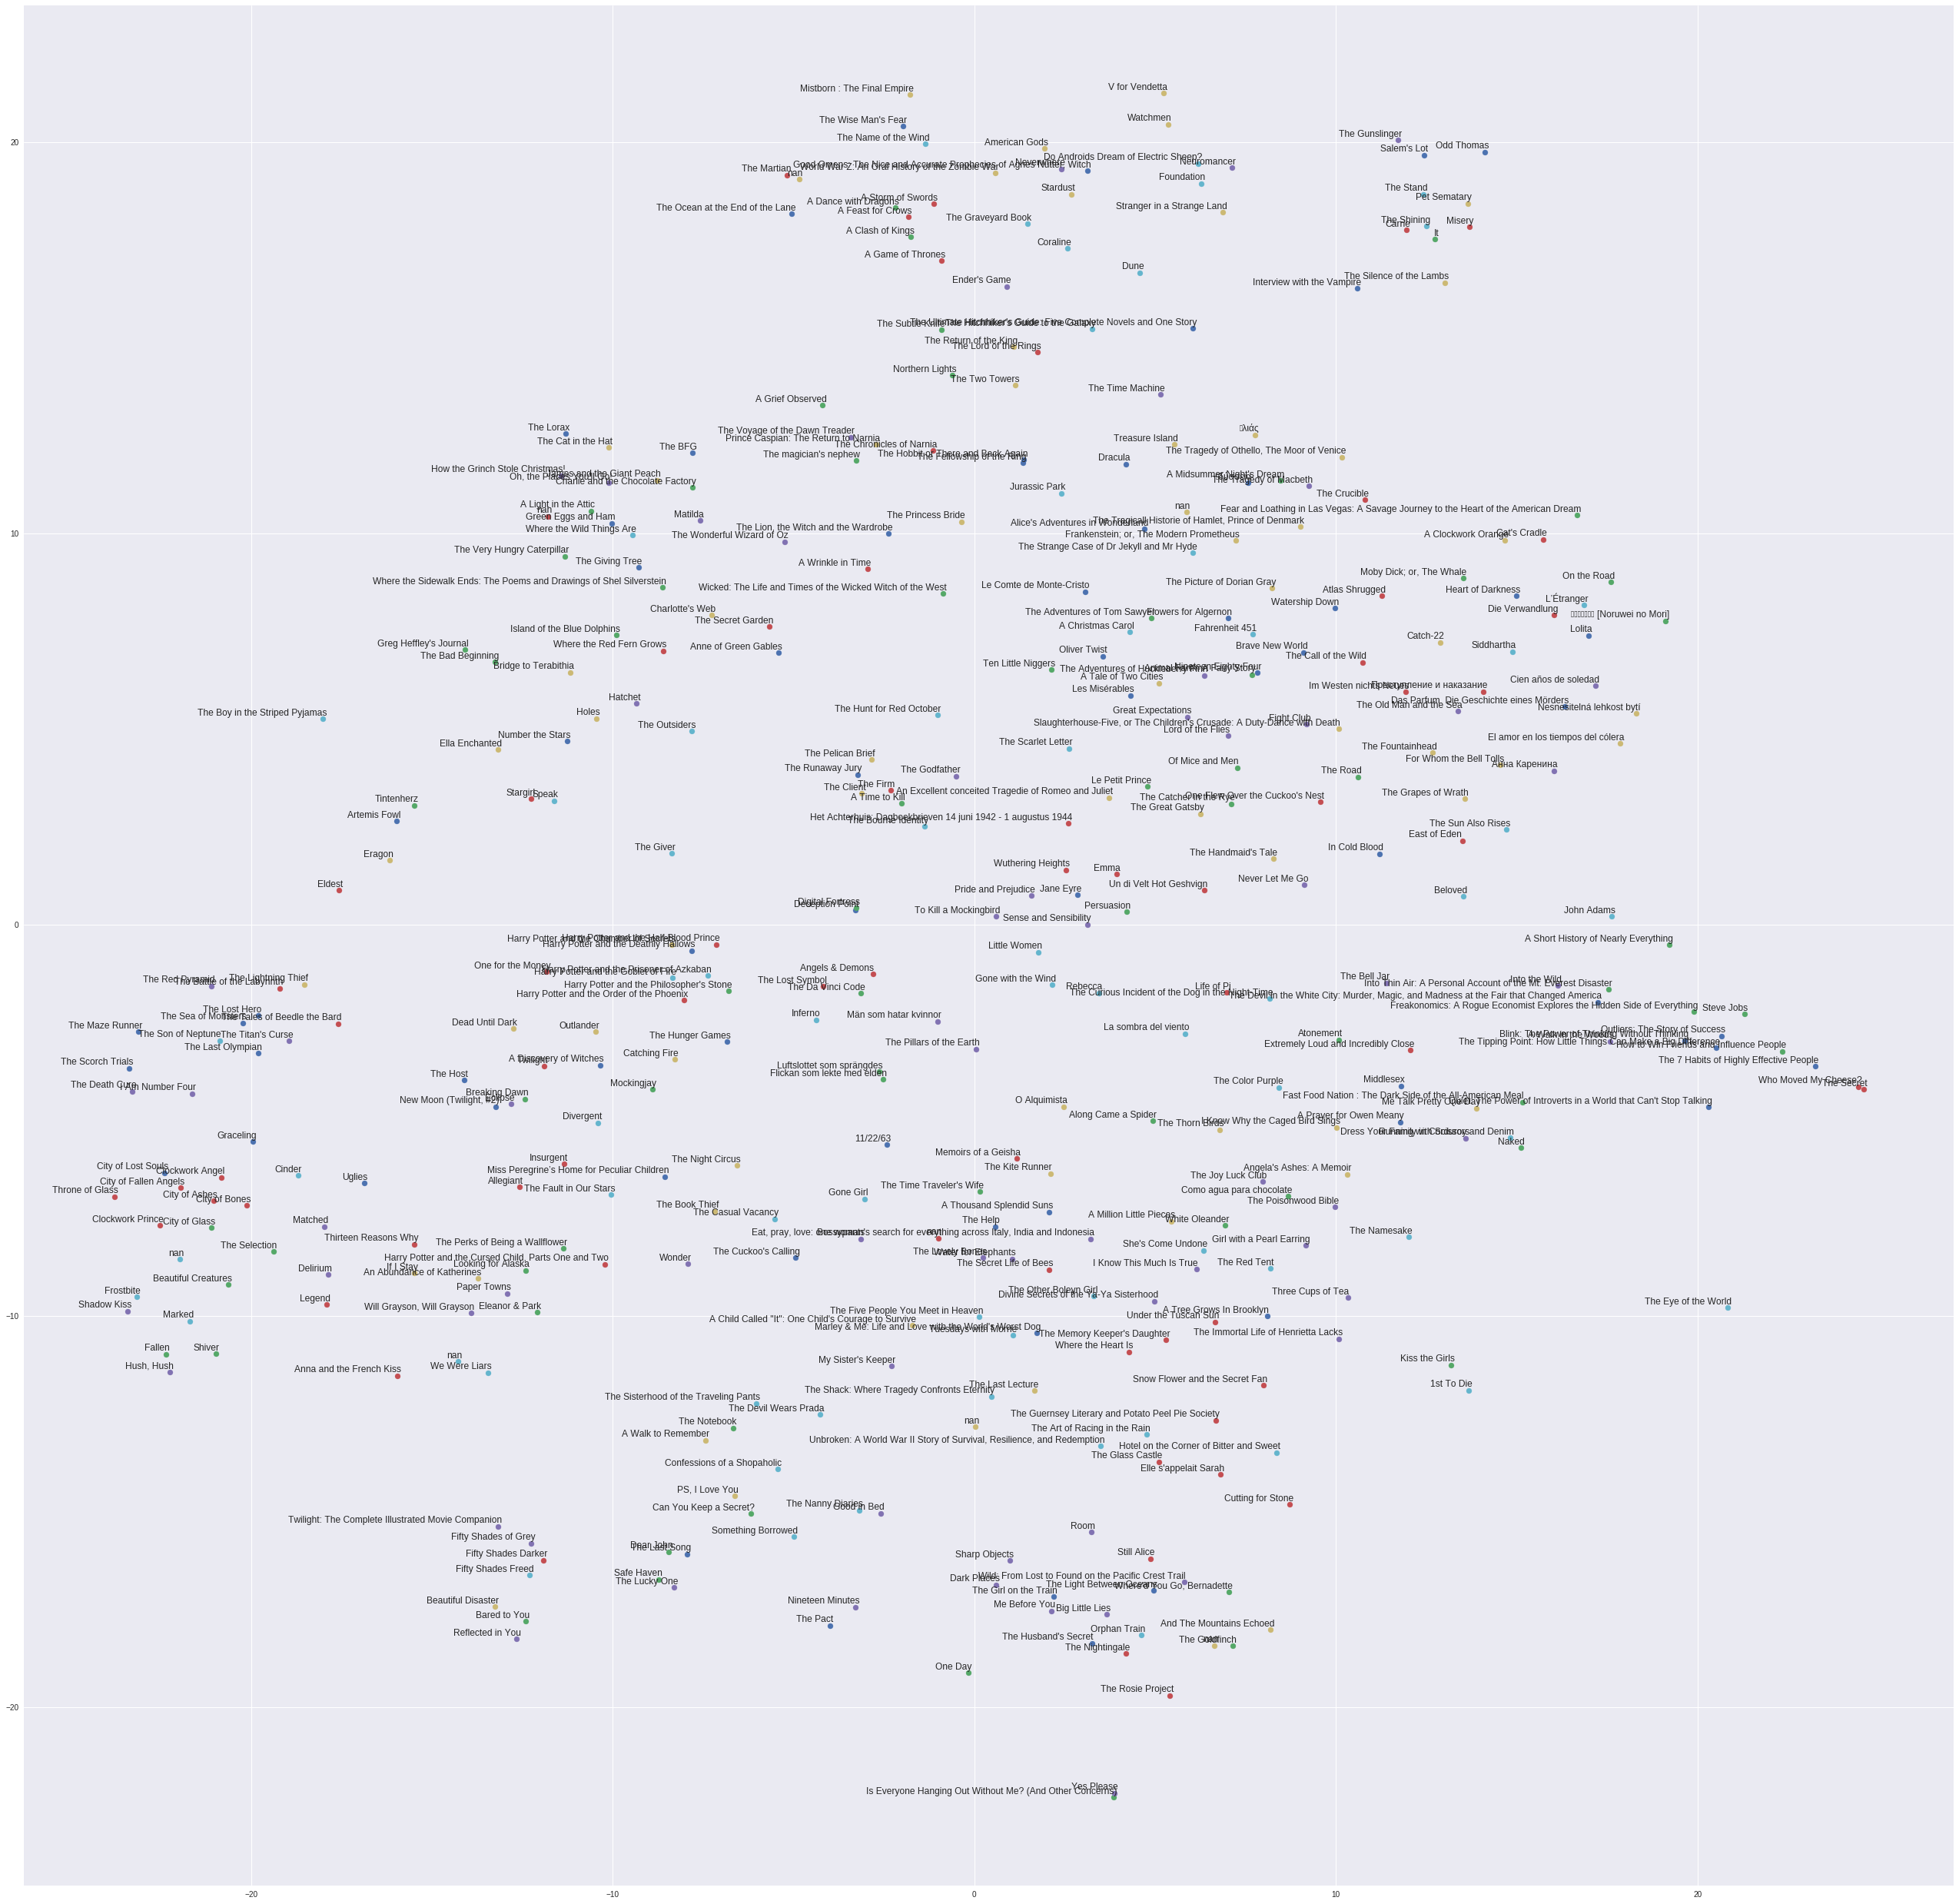

In [0]:
def plot(softmax_weightsPlot, labels):
  assert softmax_weightsPlot.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(50,50))  # in inches
  for i, label in enumerate(labels):
    x, y = softmax_weightsPlot[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

books = [bookDictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddingsSM, books)